# Práctica: Lematización para Mejora de Análisis de Sentimiento en Reseñas Multilingües


Implementar un pipeline de lematización que unifique variantes morfológicas y mejore la precisión de un modelo de análisis de sentimiento.


# Fase 0: Importacion de librerias necesarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from wordcloud import WordCloud



## Fase 1: Diagnóstico de Problemas

In [2]:
df = pd.read_csv("reviews_multilang.csv")
df.head()


,texto,idioma,sentimiento
0,La interfaz intuitiva facilita la navegación i...,es,positivo
1,El rendimiento gráfico dejó mucho que desear e...,es,negativo
2,Constantes fallos de conectividad WiFi tras la...,es,negativo
3,Sorprendido por la autonomía de la batería en ...,es,positivo
4,El sistema operativo se bloquea recurrentement...,es,negativo


In [3]:
df.count()

texto          49
idioma         49
sentimiento    49
dtype: int64

In [4]:
vectorizer = CountVectorizer()

ej_critico = "Los usuarios reportaron fallas constantes: no funciona, se traba y no responde."
# X_counts = vectorizer.fit_transform(df["texto"])  # columna de texto
X_counts = vectorizer.fit_transform([ej_critico])
token_freq = pd.DataFrame({'token': vectorizer.get_feature_names_out(), 'freq': X_counts.sum(axis=0).A1})
token_freq.sort_values(by="freq", ascending=False).head(10)


,token,freq
4,no,2
0,constantes,1
1,fallas,1
2,funciona,1
3,los,1
5,reportaron,1
6,responde,1
7,se,1
8,traba,1
9,usuarios,1


In [5]:
!python -m spacy download es_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
nlp = spacy.load("es_core_news_sm")
doc = nlp(ej_critico)

for token in doc:
    print(token.text, token.pos_, token.lemma_)



Los DET el
usuarios NOUN usuario
reportaron VERB reportar
fallas NOUN falla
constantes ADJ constante
: PUNCT :
no ADV no
funciona VERB funcionar
, PUNCT ,
se PRON él
traba VERB trar
y CCONJ y
no ADV no
responde VERB responder
. PUNCT .


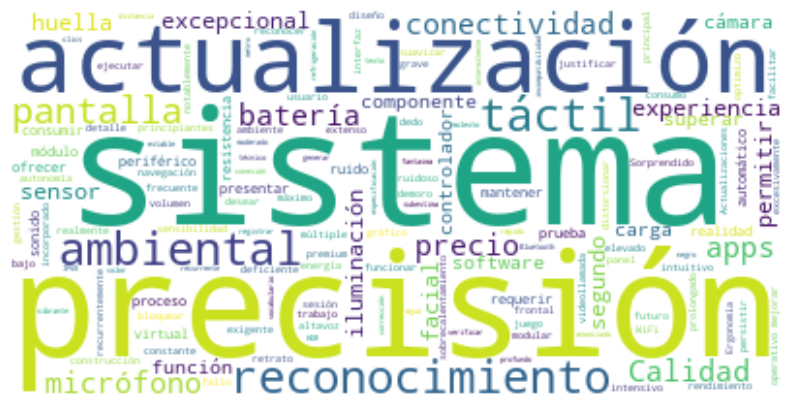

In [7]:

text = " ".join(df["texto"])
doc = nlp(text)
lemmas = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
wordcloud = WordCloud(background_color='white').generate(lemmas)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [8]:

variantes = [("fallas", "falla"), ("funciona", "funcionar"), ("trabó", "trabar"), ("responder", "responder"), ("reportaron", "reportar")]
pd.DataFrame(variantes, columns=["Forma Original", "Lema"])


,Forma Original,Lema
0,fallas,falla
1,funciona,funcionar
2,trabó,trabar
3,responder,responder
4,reportaron,reportar


## Fase 2: Implementación del Lematizador

In [9]:
!pip install nltk


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import nltk

In [11]:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lematizar(texto, idioma):
    if idioma == "es":
        doc = spacy.load("es_core_news_sm")(texto)
        return [token.lemma_ for token in doc if not token.is_punct and (not token.is_stop or token.pos_ == "ADV")]
    elif idioma == "en":
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(texto)
        tagged = pos_tag(tokens)
        return [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged if word.lower() not in stopwords.words("english")]


In [13]:

print(lematizar("Los dispositivos fallaron constantemente, no funcionan bien.", "es"))


['dispositivo', 'fallar', 'constantemente', 'no', 'funcionar', 'bien']


## Fase 3: Optimización y Validación

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [15]:

df["texto_lematizado"] = df["texto"].apply(lambda x: " ".join(lematizar(x, "es")))

vectorizer = TfidfVectorizer()
x_lem = vectorizer.fit_transform(df["texto_lematizado"])
x_raw = TfidfVectorizer().fit_transform(df["texto"])
y = df["sentimiento"]

# Dividir el texto lematizado
x_train, x_test, y_train, y_test = train_test_split(x_lem, y, test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(39, 249)
(10, 249)
(39,)
(10,)


In [16]:
clf = RandomForestClassifier().fit(x_train, y_train)


In [17]:
preds = clf.predict(x_test)
print("F1-score con lematización:", f1_score(y_test, preds, average="macro"))


F1-score con lematización: 0.6


In [18]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_raw, y, test_size=0.2)

clf2 = RandomForestClassifier().fit(x_train2, y_train2)
preds2 = clf2.predict(x_test2)
print("F1-score sin lematización:", f1_score(y_test2, preds2, average="macro"))


F1-score sin lematización: 0.45054945054945056


## Fase 4: Evaluación Comparativa

In [19]:

vocab_size_raw = len(TfidfVectorizer().fit(df["texto"]).vocabulary_)
vocab_size_lem = len(TfidfVectorizer().fit(df["texto_lematizado"]).vocabulary_)
print("Reducción de vocabulario:", round((vocab_size_raw - vocab_size_lem) / vocab_size_raw * 100, 2), "%")


Reducción de vocabulario: 11.7 %
